In [1]:
import numpy as np

import torch
import torchvision
import torch.optim as optim
import torch.nn as nn

import matplotlib.pyplot as plt
import librosa
import librosa.display
#import IPython.display as ipd

import tqdm
from tqdm import tqdm

import random
import pickle

from sklearn import metrics
from sklearn.metrics import roc_curve, auc

In [2]:
allNormal = np.load("allNormal3.npy", allow_pickle=True)
allAnomaly = np.load("allAnomaly4.npy", allow_pickle=True)

In [3]:
def makeWindows(data, numWindows):
    windows = []
    intervalLength = int(430 / numWindows)
    for mspec in tqdm(range(len(data))):
        start = 0
        end = intervalLength
        for interval in range(numWindows):
            melspectrogram = data[mspec]
            window = melspectrogram[:,start:end]
            windows.append(window)
            start += intervalLength
            end += intervalLength
    return windows
        
def makeWindows2(data, numWindows): #makes the windows with the metadata to amke it reconstructable
    windows = []
    classifiers = {}
    intervalLength = int(430 / numWindows)
    for mspec in tqdm(range(len(data))):
        start = 0
        end = intervalLength
        classifiers[mspec] = data[mspec][1]
        for interval in range(numWindows):
            melspectrogram = data[mspec][0]
            window = melspectrogram[:,start:end]
            windows.append([window, mspec, interval])
            start += intervalLength
            end += intervalLength
    return windows, classifiers

def makeWindows3(data, numWindows):
    windows = []
    intervalLength = int(430 / numWindows)
    for mspec in tqdm(range(len(data))):
        start = 0
        end = intervalLength
        for interval in range(numWindows):
            melspectrogram = data[mspec][0]
            window = melspectrogram[:,start:end]
            windows.append([window, mspec, interval])
            start += intervalLength
            end += intervalLength
    return windows

def makeWindows4(data, numWindows): #makes the windows with the metadata to amke it reconstructable, takes in a singular window
    windows = []
    intervalLength = int(430 / numWindows)
    start = 0
    end = intervalLength
    classifier = data[1]
    melspectrogram = data[0]
    for interval in range(numWindows):
        window = melspectrogram[:,start:end]
        windows.append([window, interval])
        start += intervalLength
        end += intervalLength
        
    npWindows = np.array([]).reshape(0,1,11,86)
    for j in range(len(windows)):
        npWindows = np.vstack([npWindows, windows[j][0].reshape(-1,1,11,86)])
    return npWindows, classifier

def sortWindows(arr):#sorts from least to greatest in terms of the "mel-order"
    for mspec in range(len(arr)):
        for mspec2 in range(mspec, len(arr)):
            if arr[mspec][2] > arr[mspec2][2]:
                temp = arr[mspec]
                arr[mspec] = arr[mspec2]
                arr[mspec2] = temp
    return arr

def reconstruct(arr, numWindows, size): #reconstructs the Mel spectrograms after being window sliced and shuffled
    arr = arr.tolist()
    melspectrograms = []
    allRecon = []
    for melID in tqdm(range(size)):
        mspec = []
        for a in range(len(arr)):
            print(a)
            if arr[a][1] == melID:
                mspec.append(arr[a])
        sortWindows(mspec)
        mspec = np.array(mspec)
        whole = mspec[0][0]
        for time in range(1,numWindows):
            whole = np.concatenate((whole, mspec[time][0]), axis=1)
        whole = whole.tolist()
        allRecon.append(whole)
    return allRecon

def reconstruct2(numpyArray, numWindows): #reconstructs the Mel spectrograms after being window sliced and shuffled
    numpyArray = numpyArray.tolist()
    #numpyArray = sortWindows2(numpyArray)
    mspec = np.array(numpyArray)
    whole = mspec[0].reshape(11,86)
    for time in range(1,numWindows):
        whole = np.concatenate((whole, mspec[time].reshape(11,86)), axis=1)
    return whole

def sortWindows2(arr):#sorts from least to greatest in terms of the "mel-order", takes in a python list
    for mspec in range(len(arr)):
        for mspec2 in range(mspec, len(arr)):
            if arr[mspec][1] > arr[mspec2][1]:
                temp = arr[mspec]
                arr[mspec] = arr[mspec2]
                arr[mspec2] = temp
    return arr

In [4]:
class CAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential( #starting size: (11,86)
            nn.Conv2d(1,32,3), #input: 11, 86 -> 9, 84
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3), #input: 4, 42 -> 2,40
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2) #input: 2, 40 -> 1, 20
            #final: 1, 20
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2), #input: 1,20 -> 3,41
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 6, stride=2, output_padding = (1,0)) #input: 3, 41 -> 10,86
            
            #final: 10,86
        )
        
    def forward(self,x):
        x = self.encoder(x)
        x=self.decoder(x)
        return x

In [5]:
print(len(allNormal),len(allAnomaly))

5399 5469


In [6]:
test = allNormal[:]
test = test.tolist()

for i in allAnomaly:
    test.append(i)

print(len(test))

10868


In [7]:
# windows, classifiers = makeWindows2(test, 5)

In [8]:
model = pickle.load(open('fan_1.pt', 'rb'))
criterion = nn.MSELoss()
lossDictionary = {}
val_acc = -1
val_loss = []
classifiers = []


# for data in tqdm(range(len(windows))):
#     window = torch.from_numpy(windows[data][0]).type(torch.float32)
#     output = model(window.view(-1,1,11,86))
#     loss = criterion(output.view(-1,1,11,86), window.view(-1,1,11,86))
#     val_loss.append(loss)
#     if lossDictionary.get(windows[data][1]) == None:
#         lossDictionary[windows[data][1]] = [loss.item()]
#     elif lossDictionary.get(windows[data][1]) != None:
#         lossDictionary[windows[data][1]].append(loss.item())
        
for data in tqdm(range(len(test))):
    windows, classifier = makeWindows4(test[data], 5)
    classifiers.append(classifier[0])
#     windows = np.array(windows)
    windows = torch.from_numpy(windows).type(torch.float32)
    output = model(windows.view(-1,1,11,86))
    mspec = reconstruct2(output.detach().numpy(), 5)
    loss = criterion(torch.from_numpy(mspec).type(torch.float32).view(-1,1,11,430), torch.from_numpy(test[data][0]).type(torch.float32).view(-1,1,11,430))
    val_loss.append(loss)
    lossDictionary[data] = loss.item()

val_loss = np.array(val_loss)
val_loss = val_loss * -1
fpr, tpr, thresholds = metrics.roc_curve(classifiers, val_loss)
    
#AUC-ROC Graph

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(fpr, tpr, linestyle='-')

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

100%|██████████| 10868/10868 [00:27<00:00, 395.02it/s]


In [12]:
#model 17 = 0.6050896377301269
#model 18 = 0.614177516941961
#model 19 = 0.6169899134460439 
#model 20 = 0.6184910752080857 (Best Model So Far)

print(auc(fpr, tpr))

0.6184910752080857


In [13]:
#     correct = 0
# total = len(test)
# predictions = []
# #threshold = 10

# TPRs = []
# FPRS = []
# with torch.no_grad():
#     for threshold in range(0, 110, 10):
# #         TP = 0 #true positive
# #         TN = 0 #true negative
# #         FP = 0 # false positive
# #         FN = 0 # false negative
#         for j in tqdm(range(len(test))):
#             if lossDictionary[j] > threshold:
# #                 if [0,1] == classifiers[j].tolist():
#                 predictions.append([0,1])
# #                     TN += 1
# #                 else:
# #                     predictions[j] = [0,1]
# #                     FN += 1
#             elif lossDictionary[j] <= threshold:
# #                 if [1,0] == classifiers[j].tolist:
#                 predictions.append([1,0])
# #                     TP += 1
# #                 else:
# #                     predictions[j] = [1,0]
# #                     FP += 1
# #         TPR = TP / (TP+FN)
# #         FPR = FP / (FP+TN)
# #         TPRs.append(TPR)
# #         FPRs.append(FPR)

# #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
# #https://www.projectpro.io/recipes/plot-roc-curve-in-python

# print(val_acc)

(11, 430)


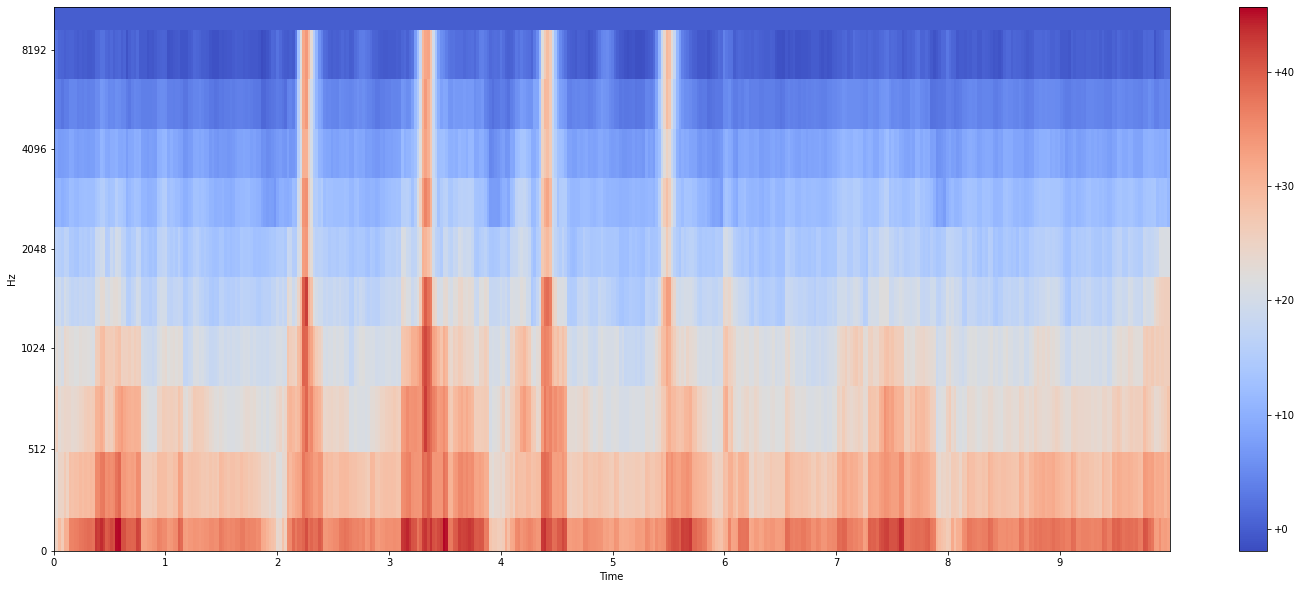

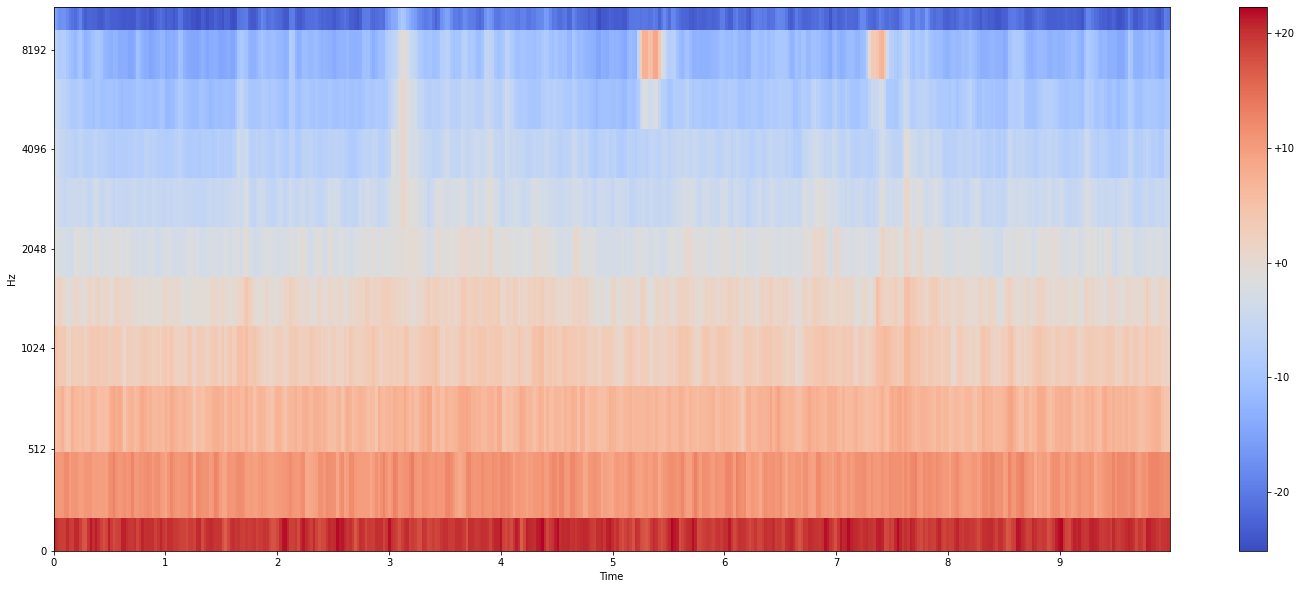

325.96588134765625


In [29]:
# a=2
# model = pickle.load(open('model_11.pt', 'rb'))
# windows, classifier = makeWindows4(test[a], 5)
# windows = torch.from_numpy(windows).type(torch.float32)
# o = model(windows.view(-1,1,11,86))
# mspec = reconstruct2(output.detach().numpy(), 5)
# print(mspec.shape)
# plt.figure(figsize=(25,10))
# librosa.display.specshow(mspec.reshape(11,430), x_axis = "time", y_axis = "mel", sr=22050)

# plt.colorbar(format="%+2.f")
# plt.show()

# plt.figure(figsize=(25,10))
# librosa.display.specshow(test[a][0].reshape(11,430), x_axis = "time", y_axis = "mel", sr=22050)

# plt.colorbar(format="%+2.f")
# plt.show()

# thing = criterion(torch.from_numpy(mspec).type(torch.float32).view(1,11,430), torch.from_numpy(test[a][0]).type(torch.float32).view(-1,1,11,430))
# print(thing.item())

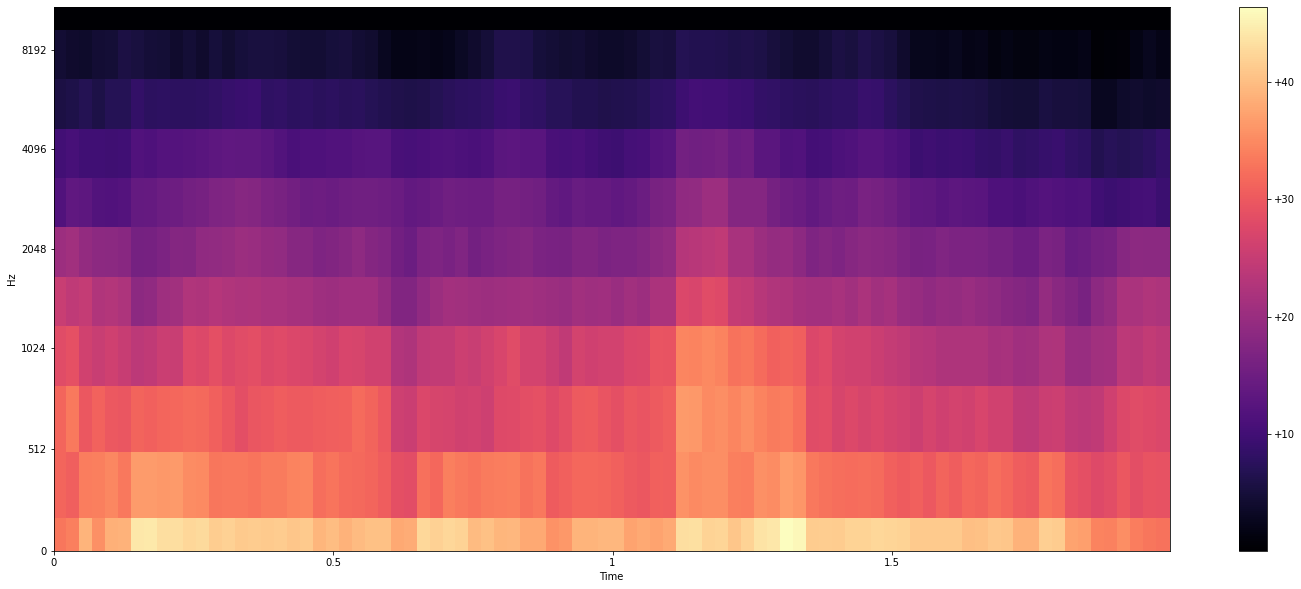

TypeError: Cannot interpret 'torch.float32' as a data type

<Figure size 1800x720 with 0 Axes>

In [15]:
# plt.figure(figsize=(25,10))
# librosa.display.specshow(o[0].detach().numpy().reshape(11,86), x_axis = "time", y_axis = "mel", sr=22050)

# plt.colorbar(format="%+2.f")
# plt.show()

# plt.figure(figsize=(25,10))
# librosa.display.specshow(windows[0].reshape(11,86), x_axis = "time", y_axis = "mel", sr=22050)

# plt.colorbar(format="%+2.f")
# plt.show()

# thing = criterion(torch.from_numpy(mspec).type(torch.float32).view(1,11,430), torch.from_numpy(test[a]).type(torch.float32).view(-1,1,11,430))
# print(thing.item())

In [ ]:
# a = 2
# w, c = makeWindows2(test[0:2], 5)
# output = model(torch.from_numpy(w[a][0]).type(torch.float32).view(-1,1,11,86))
# loss = criterion(output.view(-1,1,11,86), torch.from_numpy(w[a][0].reshape(-1,1,11,86)).type(torch.float32))
# print(loss.item())

In [ ]:

# # def makeWindows2(data, numWindows):
# arr2 = makeWindows3(test[0:2], 5)
# whole = []

# for data in tqdm(range(len(arr2[0:5]))):
#     window = torch.from_numpy(np.array(arr2[data][0])).type(torch.float32)
#     output = model(window.view(-1,1,11,86))
#     whole.append([output, arr2[data][1], arr2[data][2]])

# wholeNumpy = np.array([[whole[0][0].detach().numpy().reshape(11,86), whole[0][1], whole[0][2]], [whole[1][0].detach().numpy().reshape(11,86), whole[1][1], whole[1][2]], [whole[2][0].detach().numpy().reshape(11,86), whole[2][1], whole[2][2]], [whole[3][0].detach().numpy().reshape(11,86), whole[3][1], whole[3][2]], [whole[4][0].detach().numpy().reshape(11,86), whole[4][1], whole[4][2]]])
# #     loss = criterion(output.view(-1,1,11,86), window.view(-1,1,11,86))
# melspec = reconstruct(np.array(wholeNumpy), 5, 1)
# melspec = np.array(melspec)

# plt.figure(figsize=(25,10))
# librosa.display.specshow(melspec.reshape(11,430), x_axis = "time", y_axis = "mel", sr=22050)

# plt.colorbar(format="%+2.f")
# plt.show()

# plt.figure(figsize=(25,10))
# librosa.display.specshow(test[0][0].reshape(11,430), x_axis = "time", y_axis = "mel", sr=22050)

# plt.colorbar(format="%+2.f")
# plt.show()
